In [1]:
import pathlib
import zipfile
import os
import tensorflow as tf
from PIL import Image as Image
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import keras

In [2]:
import keras_tuner as kt
from keras import layers
from keras.datasets import mnist
import numpy as np
import random
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [3]:
#Use extract function in Préparation de données to get correct dataset
#Need livrable2 zip in correct directory architecture
dataset_path = "../DatasetL2/Project_Dataset_Unzip/Dataset"

In [4]:
image_h = 320
image_w = 320
batch_s = 10

In [5]:
print(len(os.listdir(dataset_path))-len(os.listdir(dataset_path))*0.2)

120.0


In [5]:
def add_noise(img):
    noise_factor = 0.2
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
    img = img + noise
    np.clip(img, 0., 1.)
    return img

def noisy(img):
    img_resc = [pix*1./255 for pix in img]
    row,col,ch= img.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img_resc + gauss
    return noisy

def noisy_image(img):
    return img-50

test_dataset_path = "../DatasetL2/Project_Dataset_Unzip/"
normal_datagen = ImageDataGenerator(
        rescale=1./255,
        #preprocessing_function=noisy,
        data_format="channels_last",
        validation_split=0.20
        )
noisy_datagen = ImageDataGenerator(
        #rescale=1./255,
        preprocessing_function=noisy,
        data_format="channels_last",
        validation_split=0.20
        )
train_generator = normal_datagen.flow_from_directory(
        test_dataset_path,
        subset = 'training',
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))-len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

train_noisy_generator = noisy_datagen.flow_from_directory(
        test_dataset_path,
        subset = 'training',
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))-len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

test_generator = normal_datagen.flow_from_directory(
        test_dataset_path,
        subset = 'validation',
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

test_noisy_generator = noisy_datagen.flow_from_directory(
        test_dataset_path,
        subset = 'validation',
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

Found 120 images belonging to 1 classes.
Found 120 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


In [8]:
train_noisy= train_noisy_generator.next()
test_noisy= test_noisy_generator.next()
train = train_generator.next()
test = test_generator.next()
x_train = train
x_train_noisy = train_noisy
x_test = test
x_test_noisy = test_noisy

<class 'numpy.ndarray'>


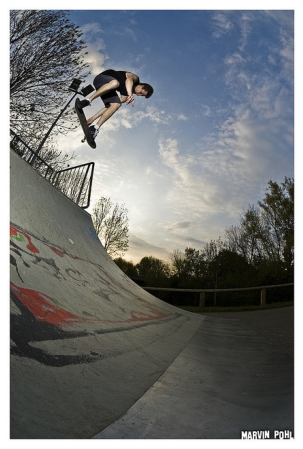

In [9]:
from keras.preprocessing import image
def display_single_image(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[i].reshape(image_h, image_w,3))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#Print 1 image for testing
img = image.load_img('../DatasetL2/Project_Dataset_Unzip/Dataset/noisy_139.jpg')  # this is a PIL image
display_single_image(img)
#display_single_image(noisy(train_generator[0][0][0]))
print(train_generator[0][0][0].__class__)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>


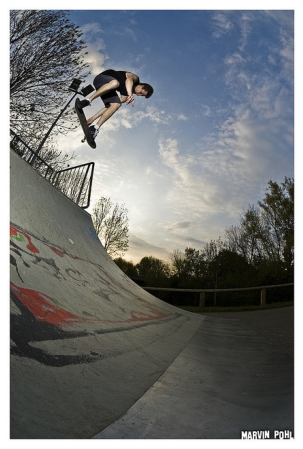

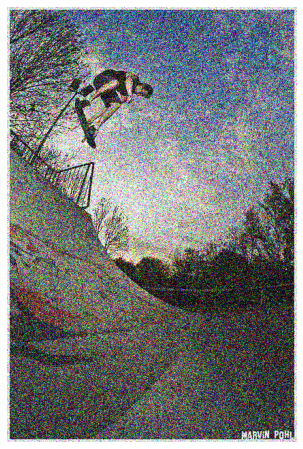

In [9]:
#img = image.img_to_array(img)
img_decode = np.array(img)
print(img_decode.__class__)
display_single_image(img_decode)
display_single_image(noisy(img_decode))

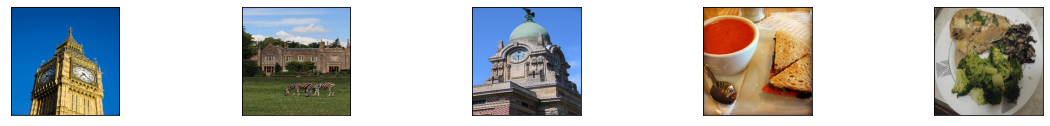

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

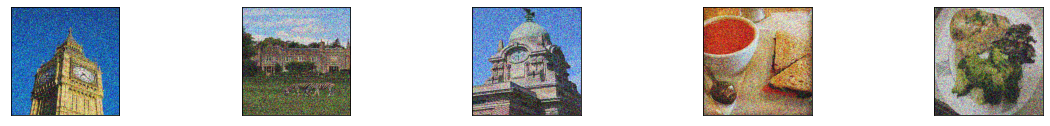

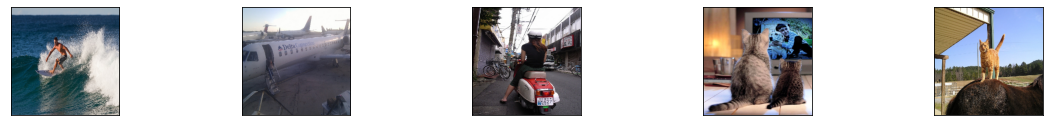

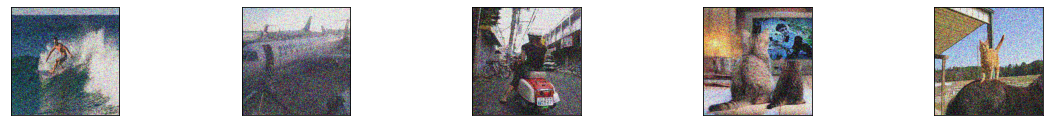

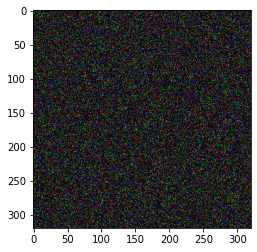

In [10]:
display_image(x_train,5)
display_image(x_train_noisy,5)
display_image(x_test,5)
display_image(x_test_noisy,5)
plt.imshow(noisy(x_test_noisy[2]))

In [11]:
name = 'L2_model.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'
checkpoint_filepath = '../model/' + name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    #save_freq="epoch",
    save_best_only=True)

In [12]:
number_epochs = 2000
input_img = keras.Input(shape=(image_h, image_w, 3))

encoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
#encoded = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
#encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)

#decoded = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
#decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded) #decoded
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

auto_encoder = keras.Model(input_img, decoded)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
auto_encoder.compile(optimizer = optimizer,
                  loss = 'mean_squared_error')
auto_encoder.summary()
history = auto_encoder.fit(x_train_noisy, x_train,
                epochs=number_epochs,
                batch_size=batch_s,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[model_checkpoint_callback]
                )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 320, 320, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 160, 160, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 40, 32)        0     

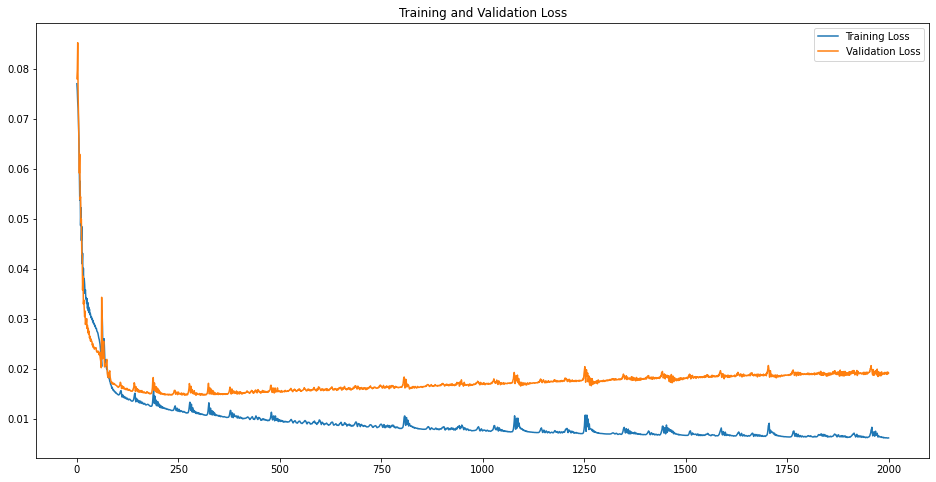

<Figure size 432x288 with 0 Axes>

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(number_epochs)
plt.figure(figsize=(16, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig("images/Courbe_loss_L2.png")

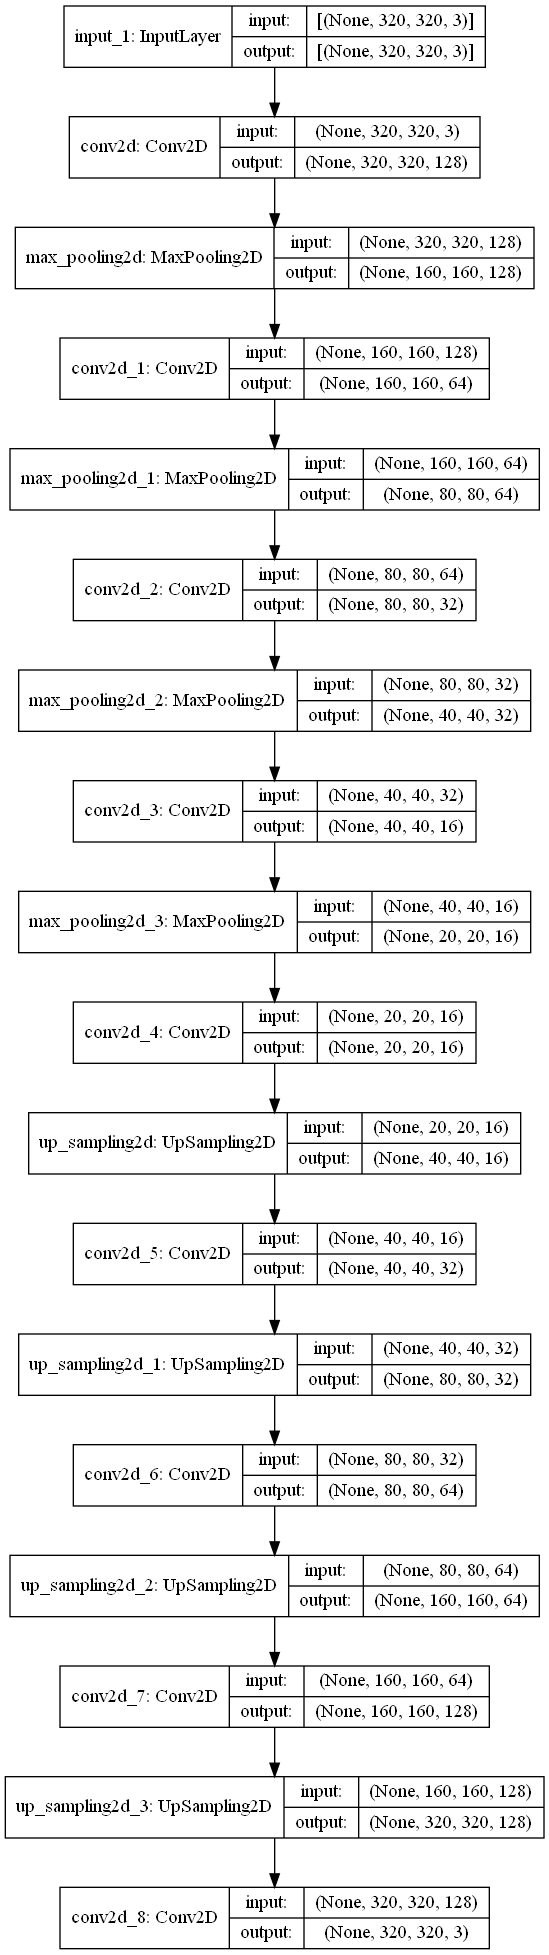

In [14]:
tf.keras.utils.plot_model(auto_encoder, show_shapes=True)

In [15]:
decoded_imgs = auto_encoder.predict(x_train_noisy, verbose=1)
print(decoded_imgs.shape)


1/1 [==============================] - 0s 117ms/step
(10, 320, 320, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

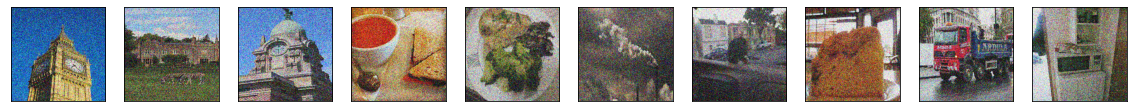

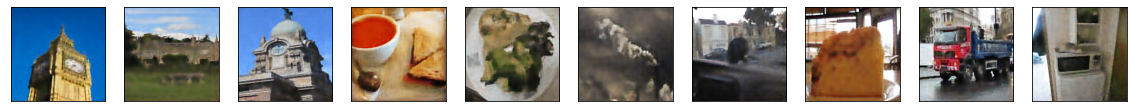

In [16]:
display_image(x_train_noisy,10)
display_image(decoded_imgs,10)

In [7]:
def build_model(hp):
  model_type = hp.Choice('model_type', ['deep_learning'])
  if model_type == 'deep_learning':

    input_img = keras.Input(shape=(image_h, image_w, 3))

    encoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    #encoded = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    #encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)

    #decoded = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    #decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded) #decoded
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

    auto_encoder = keras.Model(input_img, decoded)

    choice_optimizer = hp.Choice('optimizer', ['Adam','SGD'])
    if choice_optimizer == 'Adam':
        auto_encoder.compile(optimizer = tf.keras.optimizers.Adam(
        learning_rate= hp.Float('learning_rate', 0.001, 0.004, sampling='log')),
        loss = 'mean_squared_error')
    elif choice_optimizer == 'SGD':
        auto_encoder.compile(optimizer = tf.keras.optimizers.SGD(
        learning_rate= hp.Float('learning_rate', 0.001, 0.004, sampling='log')),
        loss = 'mean_squared_error')

    model = auto_encoder
  return model

In [18]:
print(x_train.shape)

(10, 320, 320, 3)


In [19]:
#tuner = kt.tuners.SklearnTuner(
#    oracle=kt.oracles.BayesianOptimizationOracle(
#        objective=kt.Objective('score', 'min'),
#        max_trials=10),
#    hypermodel=build_model,
#    scoring=metrics.make_scorer(metrics.hamming_loss),
#    cv=model_selection.StratifiedKFold(5),
#    directory='.',
#    project_name='my_project')

#tuner.search(x_train_noisy, x_train)

#best_model = tuner.get_best_models(num_models=1)[0]

In [6]:
normal_datagen_tuner = ImageDataGenerator(
        rescale=1./255,
        #preprocessing_function=noisy,
        data_format="channels_last",
        )
noisy_datagen_tuner = ImageDataGenerator(
        #rescale=1./255,
        preprocessing_function=noisy,
        data_format="channels_last",
        )

train_generator_tuner = noisy_datagen_tuner.flow_from_directory(
        test_dataset_path,
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))-len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

test_generator_tuner = normal_datagen_tuner.flow_from_directory(
        test_dataset_path,
        target_size=(image_h, image_w),
        #batch_size=int(len(os.listdir(dataset_path))*0.2),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

train_tuner = train_generator_tuner.next()
test_tuner = test_generator_tuner.next()
x_train_tuner = train_tuner
y_test_tuner = test_tuner

Found 150 images belonging to 1 classes.
Found 150 images belonging to 1 classes.


In [21]:
name = 'L2_Tuner_model.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'
checkpoint_filepath = '../model/' + name
model_checkpoint_callback_tuner = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    #save_freq="epoch",
    save_best_only=True)

In [9]:
import numpy as np
from sklearn import model_selection
epochs_tuner = 100
class CVTuner(kt.engine.tuner.Tuner):
  def run_trial(self, trial, x, y, batch_size=batch_s, epochs=epochs_tuner):
    cv = model_selection.KFold(5)
    val_losses = []
    for train_indices, test_indices in cv.split(x):
      x_train, x_test = x[train_indices], x[test_indices]
      y_train, y_test = y[train_indices], y[test_indices]
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,shuffle=True,
                validation_data=(x_test, y_test),
                #callbacks=[model_checkpoint_callback_tuner]
                )
      val_losses.append(model.evaluate(x_test, y_test))
    self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
    self.save_model(trial.trial_id, model,epochs_tuner)
tuner = CVTuner(
  hypermodel=build_model,
  directory='keras_tuner_dir',
  project_name='keras_tuner_demo',
  oracle=kt.oracles.BayesianOptimization(
    objective='val_loss',
    max_trials=5))
tuner.search(x_train_tuner, y_test_tuner, batch_size=batch_s, epochs=epochs_tuner)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
model_type        |deep_learning     |?                 
optimizer         |SGD               |?                 
learning_rate     |0.0015107         |?                 

Epoch 1/100
1/1 [==============================] - 1s 580ms/step - loss: 0.0771 - val_loss: 0.0816
Epoch 2/100
1/1 [==============================] - 0s 132ms/step - loss: 0.0771 - val_loss: 0.0816
Epoch 3/100
1/1 [==============================] - 0s 125ms/step - loss: 0.0771 - val_loss: 0.0816
Epoch 4/100
1/1 [==============================] - 0s 115ms/step - loss: 0.0771 - val_loss: 0.0816
Epoch 5/100
1/1 [==============================] - 0s 112ms/step - loss: 0.0771 - val_loss: 0.0816
Epoch 6/100
1/1 [==============================] - 0s 113ms/step - lo

NotFoundError: keras_tuner_dir\keras_tuner_demo\trial_b8f364b0527dd1e8d4c397a72b51457f\checkpoints\epoch_90 not found

test = tuner.get_best_hyperparameters()[0]

test_tuner = tuner.get_best_models(num_models=1)

best_model = tuner.get_best_models()[0]

best_hyperparameters = tuner.get_best_hyperparameters()[0]

model = tuner.hypermodel.build(test_tuner)

In [23]:
new_model = tf.keras.models.load_model('../model/L2_model.epoch294-loss0.0147.hdf5')

tuner_decoded_img = new_model.predict(x_train_noisy, verbose=1)
print(tuner_decoded_img.shape)

1/1 [==============================] - 0s 87ms/step
(10, 320, 320, 3)


In [ ]:
display_image(x_train_noisy,10)
display_image(tuner_decoded_img,10)

In [ ]:
from skimage.metrics import structural_similarity
ssim_list_score = []
for img_start,img_final in zip(x_train,tuner_decoded_img):
    (score, diff) = structural_similarity(img_start, img_final, multichannel=True, full=True)
    diff = (diff * 255).astype("uint8")
    ssim_list_score.append(score)
    print("SSIM: {}".format(score))
    #print("diff: {}".format(diff))
print(ssim_list_score)
display_image(x_train, 10)
display_image(tuner_decoded_img, 10)